In [9]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from dcor import distance_correlation
from adjustText import adjust_text

ineligible_ages = ['0_to_4', '5_to_9', '10_to_14', '15_to_19'] # the next strata is 20_to_24. while 20 year olds are still ineligible, the other 3 ages in this strata represent important data
age_map = {'20_to_24':22, '25_to_29':27, '30_to_34':32, '35_to_39':37, '40_to_44':42, '45_to_49':47, '50_to_54':52, '55_to_59':57, '60_to_64':62, '65_to_69':67, '70_to_74':72, '75_to_79':77, '80_to_84':82, '85_to_89':87, '90_and_over':92}

respop2020 = 'Data/respopagesextod2011to2020.csv'
shpfilelocation_sz = 'Data/MP14_SUBZONE_NO_SEA_PL.shp'
geojsonfilelocation_elect2020 = 'Data/ElectoralBoundary2020GEOJSON.geojson'
edshpfile = 'Data/Map/sz-const_map_20.shp'
ge2020 = 'Data/GE2020.csv'

In [4]:
# Prepare subzone and age dataset
df = pd.read_csv(respop2020)
df = df[df['Time']==2020] # cut down to 2020 only
df_elig = df[~df['AG'].isin(ineligible_ages)] # remove ineligible ages
df_elig['avgAge'] = df_elig['AG'].map(age_map)
df_agesum = df_elig.groupby(['SZ','avgAge'])['Pop'].sum().reset_index()
df_agesum['Pop'] = df_agesum['Pop'].astype(int)
df_agesum = df_agesum[df_agesum['Pop'] != 0] # remove rows with zero
df_meanage = df_agesum.groupby('SZ').apply(lambda g: (g['avgAge'] * g['Pop']).sum() / g['Pop'].sum()).reset_index()
df_meanage['norm_age'] = round((df_meanage[0]-22)*100/(92-22),2) # normalise to a percentage of the age range between 22 and 92
df_meanage['SZ_upper'] = df_meanage['SZ'].str.upper() # for merging with other datasets later
df_meanage

C:\Users\user\AppData\Local\Temp\ipykernel_15356\2702859925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elig['avgAge'] = df_elig['AG'].map(age_map)
C:\Users\user\AppData\Local\Temp\ipykernel_15356\2702859925.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_meanage = df_agesum.groupby('SZ').apply(lambda g: (g['avgAge'] * g['Pop']).sum() / g['Pop'].sum()).reset_index()


,SZ,0,norm_age,SZ_upper
0,Admiralty,46.549336,35.07,ADMIRALTY
1,Alexandra Hill,52.705017,43.86,ALEXANDRA HILL
2,Alexandra North,44.236181,31.77,ALEXANDRA NORTH
3,Aljunied,50.305809,40.44,ALJUNIED
4,Anak Bukit,49.875354,39.82,ANAK BUKIT
...,...,...,...,...
229,Yishun South,47.824683,36.89,YISHUN SOUTH
230,Yishun West,49.128559,38.76,YISHUN WEST
231,Yuhua East,50.587008,40.84,YUHUA EAST
232,Yuhua West,49.801617,39.72,YUHUA WEST


In [5]:
# Prepare data to combine subzone and electoral boundaries

shp_sz = gpd.read_file(shpfilelocation_sz)
geojson_elect2020 = gpd.read_file(geojsonfilelocation_elect2020)

# standardise coordinate system
if shp_sz.crs != geojson_elect2020.crs:
    shp_sz = shp_sz.to_crs(geojson_elect2020.crs)

# Using fixed buffer
buffer_distance = -0.0001 
shp_sz_buff = shp_sz.buffer(buffer_distance)
shp_sz_buffered = gpd.GeoDataFrame(shp_sz, geometry=shp_sz_buff)

geojson_elect2020_buffered = geojson_elect2020 # no need for buffer

# If using percentage buffer 
'''
buffer_percentage = 0.001

shp_sz['area'] = shp_sz.geometry.area
shp_sz['buffer_distance'] = shp_sz['area'] * buffer_percentage
shp_sz['buffered_geometry'] = shp_sz.apply(lambda row: row.geometry.buffer(row['buffer_distance']), axis=1)
shp_sz_buffered = gpd.GeoDataFrame(shp_sz, geometry='buffered_geometry')
shp_sz_buffered.crs = shp_sz.crs
'''

intersections = gpd.overlay(shp_sz_buffered, geojson_elect2020_buffered, how='intersection')
intersections.to_file("Data/Map/sz-const_map_20.shp")
#intersections[intersections['SUBZONE_N'] =='ALJUNIED'] # for visualisation and checking

intersections_map = intersections[['SUBZONE_N','Field_1','Name']] # reduced dataset
intersections_map
intersections_map.to_csv('sz-const_map_20.csv', index=False)
# Next, use this file to input the election results

C:\Users\user\AppData\Local\Temp\ipykernel_15356\3669562267.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_sz_buff = shp_sz.buffer(buffer_distance)
c:\Users\user\Documents\Python\0 Own projects\Election Analysis\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field FMEL_UPD_D create as date field, though DateTime requested.
  ogr_write(


C:\Users\user\AppData\Local\Temp\ipykernel_15356\2754137463.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\user\AppData\Local\Temp\ipykernel_15356\2754137463.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


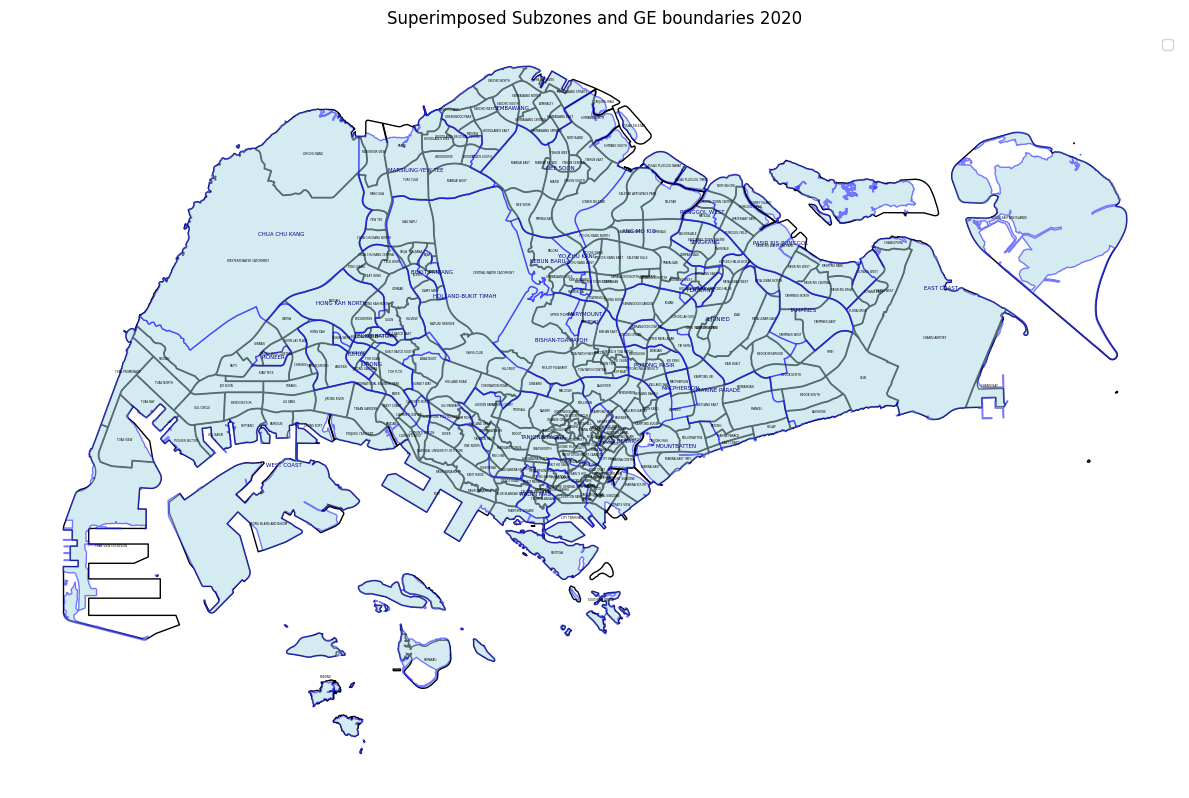

In [21]:
# Map of subzones and electoral boundaries, fopr visualisation purposes
fig, ax = plt.subplots(figsize=(12, 12))
shp_sz_buffered.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, label='Subzones')
geojson_elect2020_buffered.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='GE2020')

for idx, row in shp_sz_buffered.iterrows():
    plt.annotate(
        row['SUBZONE_N'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        fontsize=2,
        ha='center',
        color='black'
    )

for idx, row in geojson_elect2020_buffered.iterrows():
    plt.annotate(
        row.get('Field_1'), 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        fontsize=4,
        ha='center',
        color='darkblue'
    )

plt.title("Superimposed Subzones and GE boundaries 2020")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

fig.savefig('subzones-constituencies_20.png', dpi=400, bbox_inches='tight', transparent=False)

In [13]:
# Map SZ to ED (including election results)
dfge20 = pd.read_csv(ge2020)
shp_ed = gpd.read_file(edshpfile)
gdf_ge20 = shp_ed.merge(dfge20, on='Field_1', how='left') # no NaN values, checked with print(gdf_ge25.isna().any())
gdf_ge20_age = gdf_ge20.merge(df_meanage, left_on='SUBZONE_N', right_on='SZ_upper', how='left') # there are areas w/o popln data or classified differently, checked with gdf_ge20_age[gdf_ge20_age.isna().any(axis=1)]['SUBZONE_N'].unique()
gdf_ge20_age = gdf_ge20_age.dropna(subset=['SZ']) # remove all NaN, checked with print(gdf_ge20_age.isna().any())
gdf_ge20_age =  gdf_ge20_age[gdf_ge20_age['incumbent_perc'] != 100] # exclude walkovers (100%)
# gdf_ge20_age[gdf_ge20_age['Field_1'] == 'JALAN KAYU SMC' ] # for checking
# gdf_ge20_age.sort_values(by='norm_age', ascending=True, inplace=False) # for a quick overview of data

# Get the constituencies file
constituencies = gpd.read_file(geojsonfilelocation_elect2020)

# Merge in the normalised age data
gdfagegrouped = gdf_ge20_age.groupby('Field_1')['norm_age'].mean().reset_index() 
const_age = constituencies.merge(gdfagegrouped, on='Field_1', how='left')

# Merge in the voting data
const_age_vote = const_age.merge(dfge20, on='Field_1', how='left')
const_age_vote =  const_age_vote[const_age_vote['incumbent_perc'] != 100] # exclude walkovers (100%)

# Difference between vote % and age %
const_age_vote['divergence'] = (const_age_vote['norm_age'] - const_age_vote['incumbent_perc']).abs()
const_age_vote

,Name,ED_CODE,ED_DESC,FID,Field_1,geometry,norm_age,incumbent_perc,divergence
0,RADIN MAS,RM,RADIN MAS,0,RADIN MAS,"MULTIPOLYGON (((103.82485 1.266, 103.82527 1.2...",43.256250,74.01,30.753750
1,MOUNTBATTEN,MB,MOUNTBATTEN,1,MOUNTBATTEN,"MULTIPOLYGON (((103.92027 1.30079, 103.92017 1...",40.280000,73.82,33.540000
2,TANJONG PAGAR,TP,TANJONG PAGAR,2,TANJONG PAGAR,"MULTIPOLYGON (((103.8458 1.26163, 103.8464 1.2...",39.241923,63.10,23.858077
3,JALAN BESAR,JB,JALAN BESAR,3,JALAN BESAR,"MULTIPOLYGON (((103.87383 1.28217, 103.87385 1...",41.753667,65.36,23.606333
4,MACPHERSON,MP,MACPHERSON,4,MACPHERSON,"MULTIPOLYGON (((103.88182 1.31494, 103.88221 1...",40.580000,71.74,31.160000
5,PIONEER,PI,PIONEER,5,PIONEER,"MULTIPOLYGON (((103.7083 1.34003, 103.70895 1....",34.815000,62.00,27.185000
6,POTONG PASIR,PS,POTONG PASIR,6,POTONG PASIR,"MULTIPOLYGON (((103.88897 1.33357, 103.88896 1...",38.832000,60.67,21.838000
7,YUHUA,YH,YUHUA,7,YUHUA,"MULTIPOLYGON (((103.7373 1.34596, 103.73681 1....",36.513333,70.54,34.026667
8,BUKIT BATOK,BK,BUKIT BATOK,8,BUKIT BATOK,"MULTIPOLYGON (((103.7484 1.35234, 103.7474 1.3...",36.756667,54.80,18.043333
9,JURONG,JR,JURONG,9,JURONG,"MULTIPOLYGON (((103.7373 1.34596, 103.7366 1.3...",38.446471,74.61,36.163529


In [14]:
# Get dataset of opposition wins
gdf_opposition_wins = const_age_vote[const_age_vote['incumbent_perc'] < 50]
gdf_opposition_wins

,Name,ED_CODE,ED_DESC,FID,Field_1,geometry,norm_age,incumbent_perc,divergence
14,HOUGANG,HG,HOUGANG,14,HOUGANG,"MULTIPOLYGON (((103.88546 1.3681, 103.88548 1....",38.033333,38.79,0.756667
17,ALJUNIED,AJ,ALJUNIED,17,ALJUNIED,"MULTIPOLYGON (((103.91751 1.38235, 103.91563 1...",38.548125,40.05,1.501875
20,SENGKANG,SK,SENGKANG,20,SENGKANG,"MULTIPOLYGON (((103.90148 1.39811, 103.90137 1...",33.952500,47.88,13.927500


In [15]:
# Calculate distance correlation
distcorrelation = distance_correlation(const_age_vote['norm_age'],const_age_vote['incumbent_perc'])
print(distcorrelation)

0.27397321013586085


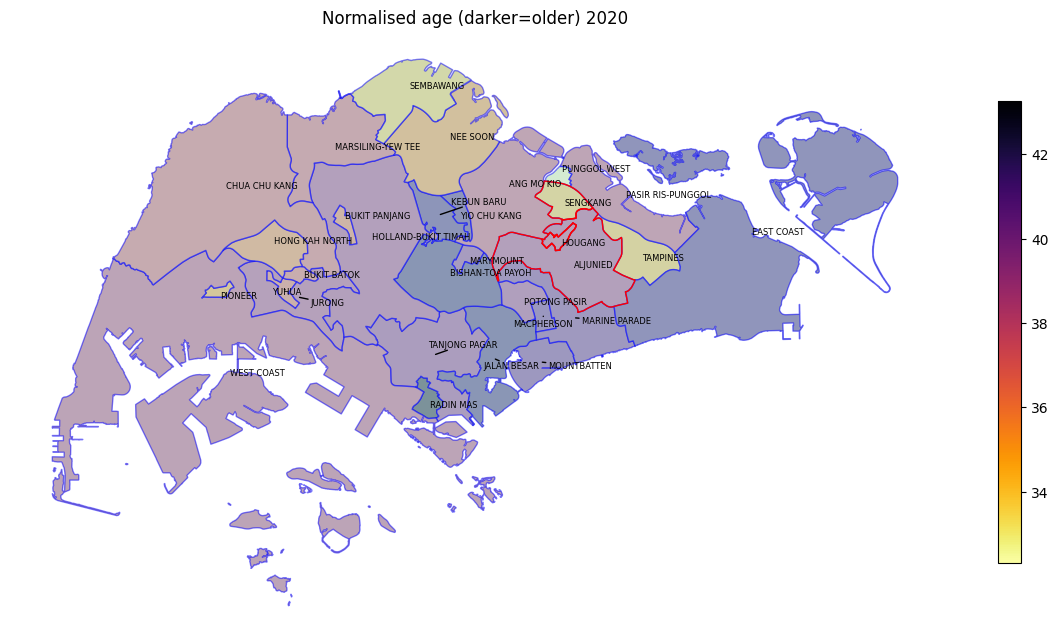

In [22]:
# Visualise age
fig, ax = plt.subplots(figsize=(15, 12))

const_age_vote.plot(column='norm_age', 
         cmap='inferno_r',         
         ax=ax,
         legend=True,
         markersize=5,        
         alpha=0.7)

# adjust colorbar
cbar_ax = fig.axes[-1]
box = cbar_ax.get_position()
cbar_ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # shrink width by 50%

# electoral boundaries
constituencies.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='GE2025')
# opposition wins
gdf_opposition_wins.plot(ax=ax, edgecolor='red', facecolor='none', alpha=1, linewidth=1, label='Opposition wins')

# Prepare the labels 
texts = []
for idx, row in constituencies.iterrows():
    centroid = row.geometry.centroid
    name = row.get('Field_1', f"Feature {idx}")  # fallback if 'name' column doesn't exist
    texts.append(ax.text(centroid.x, centroid.y, name, fontsize=6))

# Adjust labels to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black'))


plt.title("Normalised age (darker=older) 2020")
plt.axis('off')
plt.show()
fig.savefig('normalised_age_20.png', dpi=300, bbox_inches='tight', transparent=False)

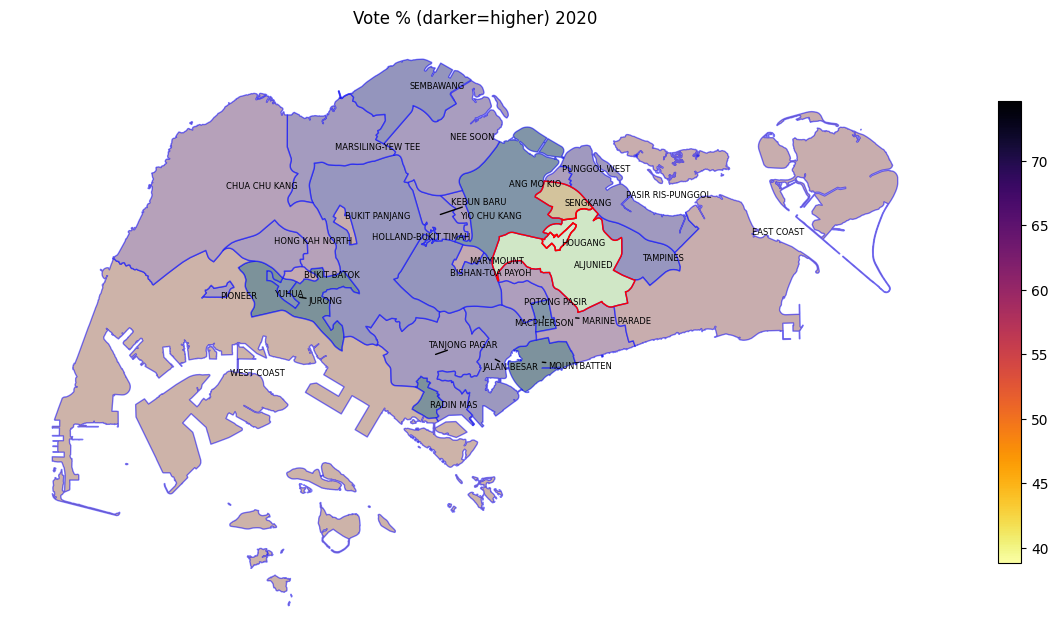

In [23]:
# Visualise vote %
fig, ax = plt.subplots(figsize=(15, 12))

const_age_vote.plot(column='incumbent_perc', 
         cmap='inferno_r',         
         ax=ax,
         legend=True,
         markersize=5,        
         alpha=0.7)

# adjust colorbar
cbar_ax = fig.axes[-1]
box = cbar_ax.get_position()
cbar_ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # shrink width by 50%

# electoral boundaries
constituencies.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='GE2025')
# opposition wins
gdf_opposition_wins.plot(ax=ax, edgecolor='red', facecolor='none', alpha=1, linewidth=1, label='Opposition wins')

# Prepare the labels 
texts = []
for idx, row in constituencies.iterrows():
    centroid = row.geometry.centroid
    name = row.get('Field_1', f"Feature {idx}")  # fallback if 'name' column doesn't exist
    texts.append(ax.text(centroid.x, centroid.y, name, fontsize=6))

# Adjust labels to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black'))


plt.title("Vote % (darker=higher) 2020")
plt.axis('off')
plt.show()
fig.savefig('vote_perc_20.png', dpi=300, bbox_inches='tight', transparent=False)

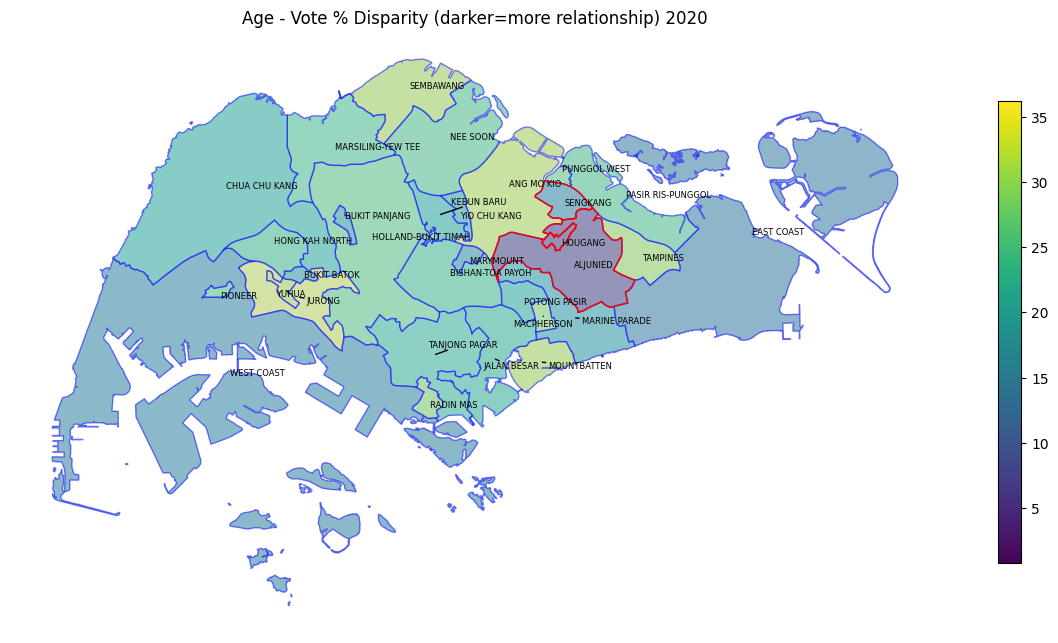

In [25]:
# Visualise age-vote % disparity
fig, ax = plt.subplots(figsize=(15, 12))

const_age_vote.plot(column='divergence', 
         cmap='viridis',         
         ax=ax,
         legend=True,
         markersize=5,        
         alpha=0.7)

# adjust colorbar
cbar_ax = fig.axes[-1]
box = cbar_ax.get_position()
cbar_ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # shrink width by 50%

# electoral boundaries
constituencies.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='GE2025')
# opposition wins
gdf_opposition_wins.plot(ax=ax, edgecolor='red', facecolor='none', alpha=1, linewidth=1, label='Opposition wins')

# Prepare the labels 
texts = []
for idx, row in constituencies.iterrows():
    centroid = row.geometry.centroid
    name = row.get('Field_1', f"Feature {idx}")  # fallback if 'name' column doesn't exist
    texts.append(ax.text(centroid.x, centroid.y, name, fontsize=6))

# Adjust labels to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black'))


plt.title("Age - Vote % Disparity (darker=more relationship) 2020")
plt.axis('off')
plt.show()
fig.savefig('age-vote_disparity_20.png', dpi=300, bbox_inches='tight', transparent=False)

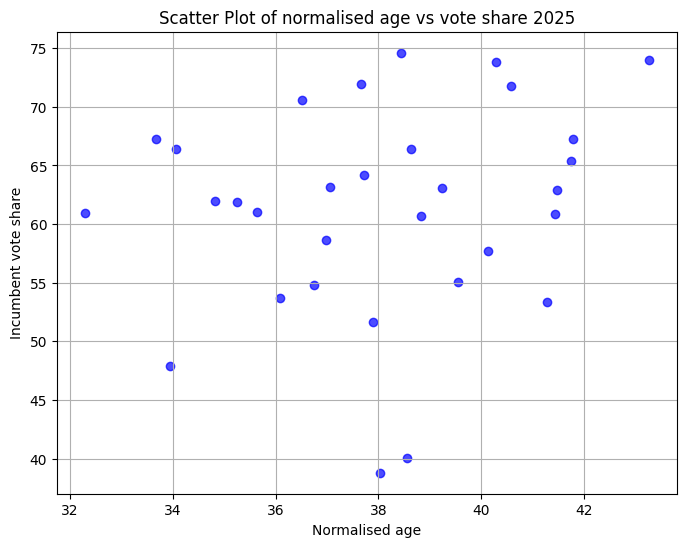

In [28]:
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(const_age_vote['norm_age'], const_age_vote['incumbent_perc'], color='blue', alpha=0.7)

# Add labels and title
plt.xlabel("Normalised age")
plt.ylabel("Incumbent vote share")
plt.title("Scatter Plot of normalised age vs vote share 2025")
plt.grid(True)

plt.savefig("scatter_plot_age_votes_2020.png", dpi=300, bbox_inches='tight')
plt.show()